In [1]:
#default_exp training

In [2]:
#hide
#export
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *
from fastai.vision.gan import *
import fastai.vision.image as im
from PIL import Image

import numpy as np

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import init
import torchvision

from torch.utils.data import DataLoader
from torch.utils.data.dataset import TensorDataset
import pdb

from HiDT.building_blocks import *
from HiDT.adaptive_unet import *
from HiDT.data_bunch import *
from HiDT.discriminators import *
from HiDT.losses import *

# HiDT Model Flow

<img src="model.png">

In [3]:
#export
class HiDT(Learner):
    "A gan learner to train a HiDT model"
    def __init__(self, data:DataBunch, content_encoder:nn.Module, style_encoder:nn.Module, 
                 decoder:nn.Module, discriminator:nn.Module, cdiscriminator: nn.Module, gen_loss_func:LossFunction,
                 crit_loss_func:LossFunction, n_crit=None, n_gen=None, switcher:Callback=None, gen_first:bool=False, switch_eval:bool=True,
                 show_img:bool=True, clip:float=None, **learn_kwargs):
        gan = HiDTModule(content_encoder, style_encoder, decoder, discriminator, cdiscriminator)
        loss_func = HiDTLoss(gen_loss_func, crit_loss_func, gan)
        switcher = ifnone(switcher, partial(FixedGANSwitcher, n_crit=n_crit, n_gen=n_gen))
        super().__init__(data=data, model=gan, loss_func=loss_func, callback_fns=[switcher], **learn_kwargs)
        trainer = HiDTTrainer(self, clip=clip, switch_eval=switch_eval, show_img=show_img)
        self.trainer = trainer
        self.callbacks.append(trainer)

# Model

In [4]:
#export
class HiDTModule(nn.Module):
    "Wrapper around a `generator` and a `critic` to create a GAN."
    def __init__(self, content_encoder=None, style_encoder=None, decoder=None, discriminator=None, cdiscriminator=None, gen_mode:bool=True):
        super().__init__()
        self.gen_mode = gen_mode
        self.content_encoder, self.style_encoder, self.decoder = content_encoder, style_encoder, decoder
        self.discriminator, self.cdiscriminator = discriminator, cdiscriminator
        self.segmenter = nn.Sequential(
            torchvision.models.segmentation.fcn_resnet101(pretrained=True),
            Lambda(lambda x: x['out']),
            nn.Sigmoid()
        )

    def forward(self, orig, orig2, *args):
        if self.gen_mode:
            return self.forward_gen(orig, orig2)
        else:
            return self.forward_disc(orig, orig2)
    
    def forward_gen(self, orig, orig2):
        #put original images through encoders
        orig_cont, orig_hooks = self.content_encoder(orig)
        orig_style = self.style_encoder(orig)
        
        orig2_cont, orig2_hooks = self.content_encoder(orig2)
        orig2_style = self.style_encoder(orig2)
        
        #reconstruction of original images
        orig_recon = self.decoder(orig_cont, orig_style, orig_hooks)
        orig2_recon = self.decoder(orig2_cont, orig2_style, orig2_hooks)
        
        #translated images
        one2two = self.decoder(orig_cont, orig2_style, orig_hooks)
        two2one = self.decoder(orig2_cont, orig_style, orig2_hooks)
        
        #re-encode translated images
        one2two_style = self.style_encoder(one2two)
        two2one_style = self.style_encoder(two2one)
        one2two_cont, one2two_hooks = self.content_encoder(one2two)
        two2one_cont, two2one_hooks = self.content_encoder(two2one)
        
        #re-decode translated images for cycle loss
        cycled_orig = self.decoder(one2two_cont, two2one_style, one2two_hooks)
        cycled_orig2 = self.decoder(two2one_cont, one2two_style, two2one_hooks)
        
        #random style translation
        rand_style = torch.randn(orig.shape[0], 3)
        one_rand = self.decoder(orig_cont, rand_style, orig_hooks)
        two_rand = self.decoder(orig2_cont, rand_style, orig2_hooks)
        
        #encoder random style image
        one_rand_cont, one_rand_hooks = self.content_encoder(one_rand)
        two_rand_cont, two_rand_hooks = self.content_encoder(two_rand)
        one_rand_style = self.style_encoder(one_rand)
        two_rand_style = self.style_encoder(two_rand)
        
        #random image reconstructions
        one_rand_recon = self.decoder(one_rand_cont, one_rand_style, one_rand_hooks)
        two_rand_recon = self.decoder(two_rand_cont, two_rand_style, two_rand_hooks)
        
        #segmented images
        orig_seg = self.segmenter(orig)
        orig2_seg = self.segmenter(orig2)
        one2two_seg = self.segmenter(one2two)
        two2one_seg = self.segmenter(two2one)
        one_rand_seg = self.segmenter(one_rand)
        two_rand_seg = self.segmenter(two_rand)
        
        #discrinate generated images
        one2twou = self.discriminator(one2two)
        two2oneu = self.discriminator(two2one)
        one_randu = self.discriminator(one_rand)
        two_randu = self.discriminator(two_rand)
        one2twoc = self.cdiscriminator(one2two, orig2_style)
        two2onec = self.cdiscriminator(two2one, orig_style)
        one_randc = self.cdiscriminator(one_rand, rand_style)
        two_randc = self.cdiscriminator(two_rand, rand_style)
        
        #lots of losses
        return [orig, orig2, orig_recon, orig2_recon, orig_style, orig2_style, orig_cont, orig2_cont, \
                one2twou, two2oneu, one2two_style, two2one_style, one2two_cont, two2one_cont, cycled_orig, \
               cycled_orig2, one_randu, two_randu, one_rand_cont, two_rand_cont, one_rand_style, two_rand_style, \
               one_rand_recon, two_rand_recon, rand_style, one2twoc, two2onec, one_randc, two_randc, \
               orig_seg, orig2_seg, one2two_seg, two2one_seg, one_rand_seg, two_rand_seg]
    
    def forward_disc(self, orig, orig2):
        
        #put original images through encoders
        orig_cont, orig_hooks = self.content_encoder(orig)
        orig_style = self.style_encoder(orig)
        
        orig2_cont, orig2_hooks = self.content_encoder(orig2)
        orig2_style = self.style_encoder(orig2)
        
        #translated images
        one2two = self.decoder(orig_cont, orig2_style, orig_hooks)
        two2one = self.decoder(orig2_cont, orig_style, orig2_hooks)
        
        #discriminate
        one2twou = self.discriminator(one2two)
        two2oneu = self.discriminator(two2one)
        origu = self.discriminator(orig)
        orig2u = self.discriminator(orig2)
        one2twoc = self.cdiscriminator(one2two, torch.tensor(orig2_style))
        two2onec = self.cdiscriminator(two2one, torch.tensor(orig_style))
        origc = self.cdiscriminator(orig, torch.tensor(orig_style))
        orig2c = self.cdiscriminator(orig2, torch.tensor(orig2_style))
        
        
        return origu, orig2u, one2twou, two2oneu, one2twoc, two2onec, origc, orig2c

    def switch(self, gen_mode:bool=None):
        "Put the model in generator mode if `gen_mode`, in critic mode otherwise."
        self.gen_mode = (not self.gen_mode) if gen_mode is None else gen_mode

```python
#export
class HiDTModule(nn.Module):
    "Wrapper around a `generator` and a `critic` to create a GAN."
    def __init__(self, content_encoder=None, style_encoder=None, decoder=None, discriminator=None, cdiscriminator=None, gen_mode:bool=True):
        super().__init__()
        self.gen_mode = gen_mode
        self.content_encoder, self.style_encoder, self.decoder = content_encoder, style_encoder, decoder
        self.discriminator, self.cdiscriminator = discriminator, cdiscriminator
        self.segmenter = nn.Sequential(
            torchvision.models.segmentation.fcn_resnet101(pretrained=True),
            Lambda(lambda x: x['out']),
            nn.Sigmoid()
        )

    def forward(self, orig, orig2, *args):
        if self.gen_mode:
            return self.forward_gen(orig, orig2)
        else:
            return self.forward_disc(orig, orig2)
    
    def forward_gen(self, orig, orig2):
        #put original images through encoders
        orig_cont, orig_hooks = self.content_encoder(orig)
        orig_style = self.style_encoder(orig)
        
        orig2_cont, orig2_hooks = self.content_encoder(orig2)
        orig2_style = self.style_encoder(orig2)
        
        #reconstruction of original images
        orig_recon = self.decoder(orig_cont, orig_style, orig_hooks)
        orig2_recon = self.decoder(orig2_cont, orig2_style, orig2_hooks)
        
        #translated images
        one2two = self.decoder(orig_cont, orig2_style, orig_hooks)
        two2one = self.decoder(orig2_cont, orig_style, orig2_hooks)
        
        #re-encode translated images
        one2two_style = self.style_encoder(one2two)
        two2one_style = self.style_encoder(two2one)
        one2two_cont, one2two_hooks = self.content_encoder(one2two)
        two2one_cont, two2one_hooks = self.content_encoder(two2one)
        
        #re-decode translated images for cycle loss
        cycled_orig = self.decoder(one2two_cont, two2one_style, one2two_hooks)
        cycled_orig2 = self.decoder(two2one_cont, one2two_style, two2one_hooks)
        
        #random style translation
        rand_style = torch.randn(orig.shape[0], 3)
        one_rand = self.decoder(orig_cont, rand_style, orig_hooks)
        two_rand = self.decoder(orig2_cont, rand_style, orig2_hooks)
        
        #encoder random style image
        one_rand_cont, one_rand_hooks = self.content_encoder(one_rand)
        two_rand_cont, two_rand_hooks = self.content_encoder(two_rand)
        one_rand_style = self.style_encoder(one_rand)
        two_rand_style = self.style_encoder(two_rand)
        
        #random image reconstructions
        one_rand_recon = self.decoder(one_rand_cont, one_rand_style, one_rand_hooks)
        two_rand_recon = self.decoder(two_rand_cont, two_rand_style, two_rand_hooks)
        
        #segmented images
        orig_seg = self.segmenter(orig)
        orig2_seg = self.segmenter(orig2)
        one2two_seg = self.segmenter(one2two)
        two2one_seg = self.segmenter(two2one)
        one_rand_seg = self.segmenter(one_rand)
        two_rand_seg = self.segmenter(two_rand)
        
        #discrinate generated images
        one2twou = self.discriminator(one2two)
        two2oneu = self.discriminator(two2one)
        one_randu = self.discriminator(one_rand)
        two_randu = self.discriminator(two_rand)
        one2twoc = self.cdiscriminator(one2two, orig2_style)
        two2onec = self.cdiscriminator(two2one, orig_style)
        one_randc = self.cdiscriminator(one_rand, rand_style)
        two_randc = self.cdiscriminator(two_rand, rand_style)
        
        #lots of losses
        return [orig, orig2, orig_recon, orig2_recon, orig_style, orig2_style, orig_cont, orig2_cont, \
                one2twou, two2oneu, one2two_style, two2one_style, one2two_cont, two2one_cont, cycled_orig, \
               cycled_orig2, one_randu, two_randu, one_rand_cont, two_rand_cont, one_rand_style, two_rand_style, \
               one_rand_recon, two_rand_recon, rand_style, one2twoc, two2onec, one_randc, two_randc, \
               orig_seg, orig2_seg, one2two_seg, two2one_seg, one_rand_seg, two_rand_seg]
    
    def forward_disc(self, orig, orig2):
        
        #put original images through encoders
        orig_cont, orig_hooks = self.content_encoder(orig)
        orig_style = self.style_encoder(orig)
        
        orig2_cont, orig2_hooks = self.content_encoder(orig2)
        orig2_style = self.style_encoder(orig2)
        
        #translated images
        one2two = self.decoder(orig_cont, orig2_style, orig_hooks)
        two2one = self.decoder(orig2_cont, orig_style, orig2_hooks)
        
        #discriminate
        one2twou = self.discriminator(one2two)
        two2oneu = self.discriminator(two2one)
        origu = self.discriminator(orig)
        orig2u = self.discriminator(orig2)
        one2twoc = self.cdiscriminator(one2two, torch.tensor(orig2_style))
        two2onec = self.cdiscriminator(two2one, torch.tensor(orig_style))
        origc = self.cdiscriminator(orig, torch.tensor(orig_style))
        orig2c = self.cdiscriminator(orig2, torch.tensor(orig2_style))
        
        
        return origu, orig2u, one2twou, two2oneu, one2twoc, two2onec, origc, orig2c

    def switch(self, gen_mode:bool=None):
        "Put the model in generator mode if `gen_mode`, in critic mode otherwise."
        self.gen_mode = (not self.gen_mode) if gen_mode is None else gen_mode
```

# Callbacks

In [5]:
#export
class HiDTTrainer(LearnerCallback):
    "Handles GAN Training."
    _order=-20
    def __init__(self, learn:Learner, switch_eval:bool=False, clip:float=None, beta:float=0.98, gen_first:bool=False,
                 show_img:bool=True):
        super().__init__(learn)
        self.switch_eval,self.clip,self.beta,self.gen_first,self.show_img = switch_eval,clip,beta,gen_first,show_img
        self.content_encoder, self.style_encoder, self.decoder, self.discriminator, self.cdiscriminator = \
            self.model.content_encoder, self.model.style_encoder, self.model.decoder, self.model.discriminator, \
            self.model.cdiscriminator

    def _set_trainable(self):
        #switching eval modes between disc and generator
        if self.gen_mode:
            self.content_encoder.train()
            self.style_encoder.train()
            self.decoder.train()
            self.discriminator.eval()
            self.cdiscriminator.eval()
            requires_grad(self.content_encoder, True)
            requires_grad(self.style_encoder, True)
            requires_grad(self.decoder, True)
            requires_grad(self.discriminator, False)
            requires_grad(self.cdiscriminator, False)
        else:
            self.content_encoder.eval()
            self.style_encoder.eval()
            self.decoder.eval()
            self.discriminator.train()
            self.cdiscriminator.train()
            requires_grad(self.content_encoder, False)
            requires_grad(self.style_encoder, False)
            requires_grad(self.decoder, False)
            requires_grad(self.discriminator, True)
            requires_grad(self.cdiscriminator, True)

    def on_train_begin(self, *args, **kwargs):
        self.gen_mode = self.gen_first
        self.switch(self.gen_mode)
        self.closses,self.glosses = [],[]
        self.imgs,self.titles = [],[]

    def on_train_end(self, *args, **kwargs):
        "Switch in generator mode for showing results."
        self.switch(gen_mode=True)

    def on_batch_begin(self, last_input, last_target, **kwargs):
        "Clamp the weights with `self.clip` if it's not None, return the correct input."
        if self.gen_mode:
            self.last_input = last_input

        return {'last_input':last_input,'last_target':last_input}

    def on_epoch_begin(self, epoch, *args, **kwargs):
        "Put the critic or the generator back to eval if necessary."
        self.switch(self.gen_mode)

    def on_epoch_end(self, pbar, epoch, last_metrics, *args, **kwargs):
        orig, orig2 = self.last_input
        orig.detach()
        orig2.detach()
        orig_cont, orig_hooks = self.content_encoder(orig)
        orig_style = self.style_encoder(orig)
        
        orig2_cont, orig2_hooks = self.content_encoder(orig2)
        orig2_style = self.style_encoder(orig2)

        one2two = self.decoder(orig_cont, orig2_style, orig_hooks).detach()
        two2one = self.decoder(orig2_cont, orig_style, orig2_hooks).detach()

        o1 = im.Image(orig[0]/2+0.5)
        o2 = im.Image(orig2[0]/2+0.5)
        o2t = im.Image(one2two[0]/2+0.5)
        t2o = im.Image(two2one[0]/2+0.5)
        self.imgs.append(o1)
        self.imgs.append(o2)
        self.imgs.append(o2t)
        self.imgs.append(t2o)


        self.titles.append(f'Epoch {epoch}-o1')
        self.titles.append(f'Epoch {epoch}-o2')
        self.titles.append(f'Epoch {epoch}-onetrans')
        self.titles.append(f'Epoch {epoch}-twotrans')

        pbar.show_imgs(self.imgs, self.titles)

        return
        
    def switch(self, gen_mode:bool=None, *args):
        "Switch the model, if `gen_mode` is provided, in the desired mode."
        self.gen_mode = (not self.gen_mode) if gen_mode is None else gen_mode
        self._set_trainable()
        self.model.switch(gen_mode)
        self.loss_func.switch(gen_mode)

In [6]:
#export
class FixedGANSwitcher(LearnerCallback):
    "Switcher to do `n_crit` iterations of the critic then `n_gen` iterations of the generator."
    def __init__(self, learn:Learner, n_crit=5, n_gen=1):
        super().__init__(learn)
        self.n_crit,self.n_gen = 1,1

    def on_train_begin(self, **kwargs):
        "Initiate the iteration counts."
        self.n_c,self.n_g = 0,0

    def on_batch_end(self, iteration, **kwargs):
        "Switch the model if necessary."
        if self.learn.trainer.gen_mode:
            self.n_g += 1
            n_iter,n_in,n_out = self.n_gen,self.n_c,self.n_g
        else:
            self.n_c += 1
            n_iter,n_in,n_out = self.n_crit,self.n_g,self.n_c
        target = n_iter if isinstance(n_iter, int) else n_iter(n_in)
        if target == n_out:
            self.learn.trainer.switch()
            self.n_c,self.n_g = 0,0

# Training

In [7]:
imlist = DoubleImageList.from_folders(Path()/'horse2zebra', 'testA', 'testB').split_by_rand_pct(0.2).label_from_folder()
data = ImageDataBunch.create_from_ll(imlist, bs=1, size=224)

In [8]:
cen = ContentEncoder()
sen = StyleEncoder()
dec = Decoder()
disc = UnconditionalDiscriminator()
cdisc = ProjectionDiscriminator()
l = nn.CrossEntropyLoss()

In [9]:
learn = HiDT(data, cen, sen, dec, disc, cdisc, l, l)

Note: author's trained for 450k iterations
<ul>
    <li>on a V100 this would take just under 3 days
    <li>onn my Macbook Pro CPU, this would take over 2.5 months

epoch,train_loss,valid_loss,time
0,2049430.125000,895929.187500,30:01


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


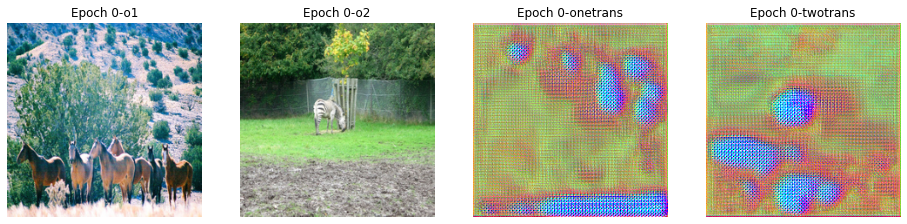

In [10]:
learn.fit(1)